In [1]:
import pandas as pd
import numpy as np
from env import user, password, host
import acquire        
from acquire import url, query
import prepare
from scipy import stats
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
df = pd.read_sql(query, url)
df

,parcelid,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,assessmentyear,regionidcounty,regionidzip,fips,transactiondate
0,11721753,3.0,2.0,1316.0,205123.0,2627.48,2016.0,3101.0,95997.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104.0,2319.90,2016.0,3101.0,97318.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606.0,543.69,2016.0,3101.0,96018.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456.0,9819.72,2016.0,1286.0,96958.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110.0,1399.27,2016.0,3101.0,96162.0,6037.0,2017-08-23
...,...,...,...,...,...,...,...,...,...,...,...
28119,11991766,6.0,2.0,2634.0,878190.0,12766.88,2016.0,3101.0,95985.0,6037.0,2017-08-31
28120,14011468,4.0,1.5,1187.0,465999.0,5552.68,2016.0,1286.0,96180.0,6059.0,2017-08-31
28121,14453399,5.0,3.0,3015.0,852813.0,11662.88,2016.0,1286.0,96983.0,6059.0,2017-08-31
28122,11128688,5.0,3.0,2992.0,1120000.0,13663.03,2016.0,3101.0,96356.0,6037.0,2017-08-31


### Takeways
- My SQL query brings in all the columns necessary to ask the questions posed by the zillow team narrowing down the database to single unit properties with transactions during May-Aug 2017
- I am bringing in 28,124 rows and 11 columns initially

# Prepare

I need to prepare one dataframe for answering the questions posed I named df that will include the tax rate, and a 2nd dataframe name df2 that is for exploring and modeling which will not include the tax rate as this would cause target leakage.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28124 entries, 0 to 28123
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      28124 non-null  int64  
 1   bedroomcnt                    28124 non-null  float64
 2   bathroomcnt                   28124 non-null  float64
 3   calculatedfinishedsquarefeet  28077 non-null  float64
 4   taxvaluedollarcnt             28123 non-null  float64
 5   taxamount                     28123 non-null  float64
 6   assessmentyear                28124 non-null  float64
 7   regionidcounty                28124 non-null  float64
 8   regionidzip                   28107 non-null  float64
 9   fips                          28124 non-null  float64
 10  transactiondate               28124 non-null  object 
dtypes: float64(9), int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,28124.0,1.304239e+07,3.747700e+06,10711855.00,11513802.75,12596700.00,1.414914e+07,1.676878e+08
bedroomcnt,28124.0,3.309487e+00,9.430731e-01,0.00,3.00,3.00,4.000000e+00,1.200000e+01
bathroomcnt,28124.0,2.316509e+00,1.016983e+00,0.00,2.00,2.00,3.000000e+00,1.100000e+01
calculatedfinishedsquarefeet,28077.0,1.934930e+03,9.956845e+02,240.00,1278.00,1675.00,2.326000e+03,1.724500e+04
taxvaluedollarcnt,28123.0,5.350049e+05,7.076811e+05,1000.00,198636.00,382798.00,6.327670e+05,2.385837e+07
taxamount,28123.0,6.508829e+03,8.221720e+03,51.26,2705.33,4735.28,7.528405e+03,2.767978e+05
assessmentyear,28124.0,2.016000e+03,0.000000e+00,2016.00,2016.00,2016.00,2.016000e+03,2.016000e+03
regionidcounty,28124.0,2.509061e+03,8.085885e+02,1286.00,1286.00,3101.00,3.101000e+03,3.101000e+03
regionidzip,28107.0,9.665625e+04,5.130263e+03,95982.00,96208.00,96414.00,9.699500e+04,3.996750e+05
fips,28124.0,6.049521e+03,2.130214e+01,6037.00,6037.00,6037.00,6.059000e+03,6.111000e+03


In [5]:
# Let's check out how many missing values we have in the df
df.isna().sum()

parcelid                         0
bedroomcnt                       0
bathroomcnt                      0
calculatedfinishedsquarefeet    47
taxvaluedollarcnt                1
taxamount                        1
assessmentyear                   0
regionidcounty                   0
regionidzip                     17
fips                             0
transactiondate                  0
dtype: int64

In [6]:
# Compared to the row count we have more than enough to drop these
df = df.dropna()

In [7]:
# Let's see if the datatypes are correct
df.dtypes

parcelid                          int64
bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
taxvaluedollarcnt               float64
taxamount                       float64
assessmentyear                  float64
regionidcounty                  float64
regionidzip                     float64
fips                            float64
transactiondate                  object
dtype: object

In [8]:
# Next we can correct data types that are wrong
df.parcelid = df.parcelid.astype('object')
df.regionidcounty = df.regionidcounty.astype('object')
df.regionidzip = df.regionidzip.astype('object')
df.fips = df.fips.astype('object')
df.taxvaluedollarcnt, df.assessmentyear = df.taxvaluedollarcnt.astype('int64'), df.assessmentyear.astype('int64')        

In [9]:
df.shape

(28060, 11)

In [10]:
df.columns

Index(['parcelid', 'bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet',
       'taxvaluedollarcnt', 'taxamount', 'assessmentyear', 'regionidcounty',
       'regionidzip', 'fips', 'transactiondate'],
      dtype='object')

In [11]:
# I dont' need regionidzip so I'll drop that here
df = df.drop(columns='regionidzip')

In [12]:
# Next I will rename the columns to be more recognizable
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms","calculatedfinishedsquarefeet": "area","taxamount":"tax_amount", "taxvaluedollarcnt": "tax_value", "fips": "zipcode", "regionidcounty": "county_id","assessmentyear": "assessment_year", "transactiondate":"transaction_date" })

In [13]:
df.shape

(28060, 10)

In [14]:
df.columns

Index(['parcelid', 'bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount',
       'assessment_year', 'county_id', 'zipcode', 'transaction_date'],
      dtype='object')

In [15]:
# Here I am going to check for possible erroneous entries and drop them
df.drop(df[df['bedrooms'] < 1].index, inplace = True)

In [16]:
df.drop(df[df['bathrooms'] < 1].index, inplace = True)

In [17]:

df.drop(df[df['area'] < 200].index, inplace = True)

In [18]:
df.dtypes

parcelid             object
bedrooms            float64
bathrooms           float64
area                float64
tax_value             int64
tax_amount          float64
assessment_year       int64
county_id            object
zipcode              object
transaction_date     object
dtype: object

In [19]:
# time to check for duplicates and remove them
# dropping ALL duplicate values
df.drop_duplicates(subset ="parcelid",
                     keep = False, inplace = True)

In [20]:
df.shape

(27981, 10)

In [21]:
df2 = df

In [22]:
df.head()

,parcelid,bedrooms,bathrooms,area,tax_value,tax_amount,assessment_year,county_id,zipcode,transaction_date
0,11721753,3.0,2.0,1316.0,205123,2627.48,2016,3101.0,6037.0,2017-07-21
1,11289917,3.0,2.0,1458.0,136104,2319.90,2016,3101.0,6037.0,2017-06-23
2,11705026,2.0,1.0,1421.0,35606,543.69,2016,3101.0,6037.0,2017-06-30
3,14269464,4.0,3.0,2541.0,880456,9819.72,2016,1286.0,6059.0,2017-06-01
4,11446756,3.0,2.0,1491.0,107110,1399.27,2016,3101.0,6037.0,2017-08-23


In [23]:
# calculate the tax rate and make a new column/feature 
df['tax_rate']= df['tax_amount']/df['tax_value']

### With the plot below I answer the request for the distribution of tax rates for each county:
- 3101 = Los Angeles,  1286 = Orange County,  2061 = Ventura
- As you can see below the average tax rate for Los Angeles is the highest, followed by Orange County and then the least is Ventura.

In [24]:
# here you can see how many homes reside in each county
df.county_id.value_counts()

3101.0    17839
1286.0     7723
2061.0     2419
Name: county_id, dtype: int64

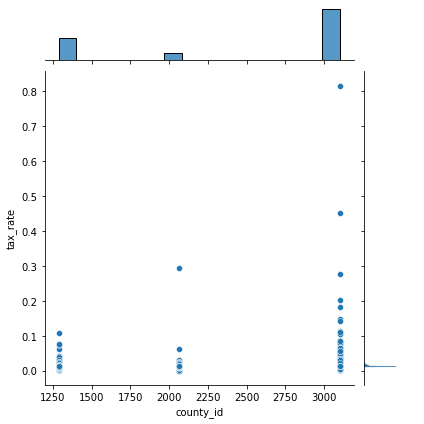

In [25]:
# here you can visualize the distribution
sns.jointplot(x=df["county_id"], y=df["tax_rate"], kind='scatter')

### Data dictionary

| Feature               | Datatype               | Description                                                |
|:----------------------|:-----------------------|:-----------------------------------------------------------|
| assessmentyear        | int64                  | The year of the property tax assessment                    | 
| bathrooms             | float64                | Number of bathrooms in home including fractional bathrooms |
| bedrooms              | float64                | Number of bedrooms in home                                 |
| area                  | float64                | Calculated total finished living area of the home          |
| parcelid              | Object                 | Unique identifier for parcels (lots)                       |
| county_id             | Object                 | County id which the property is located                    |
| zipcode               | Object                 | Zip code in which the property is located                  | | tax_amount            | float64                | The total property tax assessed for that assessment year   |
| tax_value             | int64.                 | The total tax assessed value of the parcel                 |


In [26]:
def prep_zillow_data(df):
    ''' This function preps the data by dropping rows with nulls, correcting datatypes, renaming the columns for better understanding,, 
    drops rows with erroneous entries, drops duplicates, creates a tax_rate column,
     '''
    # Compared to the row count we have more than enough to drop these
    df = df.dropna()
    # Next we can correct data types that are wrong
    df.parcelid = df.parcelid.astype('object')
    df.regionidcounty = df.regionidcounty.astype('object')
    df.regionidzip = df.regionidzip.astype('object')
    df.fips = df.fips.astype('object')
    df.taxvaluedollarcnt, df.assessmentyear = df.taxvaluedollarcnt.astype('int64'), df.assessmentyear.astype('int64')   
    # Next I will rename the columns to be more recognizable
    df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms","calculatedfinishedsquarefeet": "area","taxamount": "tax_amount", "taxvaluedollarcnt": "tax_value", "fips": "zipcode", "regionidcounty": "county_id","assessmentyear": "assessment_year", "transactiondate":"transaction_date" })
    # Here I check for erroneous entries and drop them
    df.drop(df[df['bedrooms'] < 1].index, inplace = True)
    df.drop(df[df['bathrooms'] < 1].index, inplace = True)
    df.drop(df[df['area'] < 200].index, inplace = True)
    # calculate the tax rate and make a new column/feature 
    df['tax_rate']= df['tax_amount']/df['tax_value']
    # time to check for duplicates and remove them
    # dropping ALL duplicate values
    df.drop_duplicates(subset ="parcelid",
                         keep = False, inplace = True)
    # calculate the tax rate and make a new column/feature 
    df['tax_rate']= df['tax_amount']/df['tax_value']
    return df

In [39]:
# before I split the df2 for exploration and modeling I need to drop anything that wont be helpful in exploration or will allow target leakage
df2 = df2.drop(columns=['parcelid', 'tax_value', 'tax_amount',
       'assessment_year', 'county_id', 'transaction_date',
       'tax_rate'])

In [38]:
df2.columns

Index(['parcelid', 'bedrooms', 'bathrooms', 'area', 'tax_value', 'tax_amount',
       'assessment_year', 'county_id', 'zipcode', 'transaction_date',
       'tax_rate'],
      dtype='object')

In [26]:
df.shape

(27981, 11)

In [30]:
def train_validate_test(df2, target):
    '''
    this function takes in a dataframe and splits it into 3 samples, 
    a test, which is 20% of the entire dataframe, 
    a validate, which is 24% of the entire dataframe,
    and a train, which is 56% of the entire dataframe. 
    It then splits each of the 3 samples into a dataframe with independent variables
    and a series with the dependent, or target variable. 
    The function returns train, validate, test sets and also another 3 dataframes and 3 series:
    X_train (df) & y_train (series), X_validate & y_validate, X_test & y_test. 
    '''
    # split df into test (20%) and train_validate (80%)
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)

    # split train_validate off into train (70% of 80% = 56%) and validate (30% of 80% = 24%)
    train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

        
    # split train into X (dataframe, drop target) & y (series, keep target only)
    X_train = train.drop(columns=[target])
    y_train = train[target]
    
    # split validate into X (dataframe, drop target) & y (series, keep target only)
    X_validate = validate.drop(columns=[target])
    y_validate = validate[target]
    
    # split test into X (dataframe, drop target) & y (series, keep target only)
    X_test = test.drop(columns=[target])
    y_test = test[target]
    
    return train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test

In [33]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df2, 'tax_amount')

In [37]:
df2.head()

,parcelid,bedrooms,bathrooms,area,tax_value,tax_amount,assessment_year,county_id,zipcode,transaction_date,tax_rate
0,11721753,3.0,2.0,1316.0,205123,2627.48,2016,3101.0,6037.0,2017-07-21,0.012809
1,11289917,3.0,2.0,1458.0,136104,2319.90,2016,3101.0,6037.0,2017-06-23,0.017045
2,11705026,2.0,1.0,1421.0,35606,543.69,2016,3101.0,6037.0,2017-06-30,0.015270
3,14269464,4.0,3.0,2541.0,880456,9819.72,2016,1286.0,6059.0,2017-06-01,0.011153
4,11446756,3.0,2.0,1491.0,107110,1399.27,2016,3101.0,6037.0,2017-08-23,0.013064


In [ ]:
# I am going to scale in modeling
#before I scale I need to drop parcelid, tax_value, tax_amount, assessment_year, county_id, zipcode, transaction_date and tax_rate

ConversionError: Failed to convert value(s) to axis units: array(['2017-08-31', '2017-06-30', '2017-06-16', ..., '2017-06-28',
       '2017-06-15', '2017-06-30'], dtype=object)

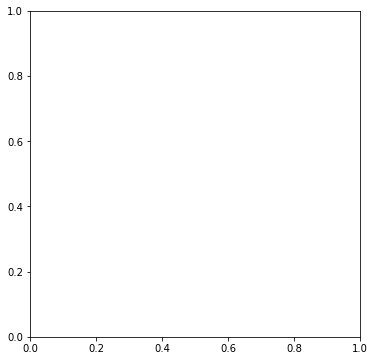

In [36]:
# def scale_dataset(train, validate, test):
#     #applying the robust scaler
#     scaler = sklearn.preprocessing.RobustScaler()
#     # Note that we only call .fit with the training data,
#     # but we use .transform to apply the scaling to all the data splits.
#     scaler.fit(X_train)

#     X_train_scaled = scaler.transform(X_train)
#     X_validate_scaled = scaler.transform(X_validate)
#     X_test_scaled = scaler.transform(X_test)
#     return X_train_scaled, X_validate_scaled, X_test_scaled

# plt.figure(figsize=(13, 6))
# plt.subplot(121)
# plt.hist(X_train, bins=25, ec='black')
# plt.title('Original')
# plt.subplot(122)
# plt.hist(X_train_scaled, bins=25, ec='black')
# plt.title('Scaled')

In [ ]:
scale_dataset(train, validate, test)

#### Takeaways
- I used the prep_zillow_data to clean and prepare the dataframe
- I kept the zipcode column to answer the question posed about county tax_rate but drop it in df2 which I will use for exploration and modeling.